In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
# from opendp.smartnoise.synthesizers.mwem import MWEMSynthesizer
from snsynth import MWEMSynthesizer
from snsynth import QUAILSynthesizer
from snsynth.pytorch import PytorchDPSynthesizer
from snsynth.pytorch.nn import DPCTGAN

from diffprivlib.models import LogisticRegression as DPLR

# 4. Adult dataset

## 4.1 Non-private data processing

In [3]:
# Read in the original data
adult_cols = ['age','workclass', 'fnlwgt', 'education', 'education_num', 'marital', 
              'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
              'hours_week', 'native_country', 'label']
adult_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
adult_data = pd.read_csv(adult_path, skipinitialspace=True, names=adult_cols, index_col=False)
adult_data.head()

,age,workclass,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hours_week,native_country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
workclass = {
    0:"Private",
    -1:"Self-emp-not-inc",
    1:"Local-gov",
    -2:"State-gov",
    2:"Self-emp-inc",
    -3:"Federal-gov",
    3:"Without-pay",
    -4:"Never-worked"
}

education = {
    0:"HS-grad",
    -1:"Some-college",
    1:"Bachelors",
    -2:"Masters",
    2:"Assoc-voc",
    -3:"11th",
    3:"Assoc-acdm",
    -4:"10th",
    4:"7th-8th",
    -5:"Prof-school",
    5:"9th",
    -6:"12th",
    6:"Doctorate",
    -7:"5th-6th",
    7:"1st-4th",
    -8:"Preschool"
}

occupation = {
    0:"Prof-specialty",
    -1:"Craft-repair",
    1:"Exec-managerial",
    -2:"Adm-clerical",
    2:"Sales",
    -3:"Other-service",
    3:"Machine-op-inspct",
    -4:"Transport-moving",
    4:"Handlers-cleaners",
    -5:"Farming-fishing",
    5:"Tech-support",
    -6:"Protective-serv",
    6:"Priv-house-serv",
    -7:"Armed-Forces"
}

relationship = {
    0:"Husband",
    -1:"Not-in-family",
    1:"Own-child",
    -2:"Unmarried",
    2:"Wife",
    -3:"Other-relative"
}

race = {
    0:"White",
    -1:"Black",
    1:"Asian-Pac-Islander",
    -2:"Amer-Indian-Eskimo",
    2:"Other"
}

In [5]:
def process_adult(df):

    # Remove fnlwgt and native_country column 
    df = df.drop(["fnlwgt", "native_country", "capital_gain", "capital_loss", "marital"], axis=1)
    
    # Remove missing values
    df = df[~df.eq("?").any(1)]
    
    # Normalize the numerical features
    #numerical_features = ["age", "education_num", "hours_week"]
    #scaler = MinMaxScaler()
    #df[numerical_features] = scaler.fit_transform(df[numerical_features])
    
    # Encode the categorical features
    categorical_features = ["workclass", "education", "occupation", "relationship", "race"]
    df["workclass"] = df["workclass"].map({v: k for k, v in workclass.items()})
    df["education"] = df["education"].map({v: k for k, v in education.items()})
    df["occupation"] = df["occupation"].map({v: k for k, v in occupation.items()})
    df["relationship"] = df["relationship"].map({v: k for k, v in relationship.items()})
    df["race"] = df["race"].map({v: k for k, v in race.items()})
    
    # Keep separate variabels with labels of outcome + protected classes for downstream plots, tables, etc
    df["gender_labs"] = df["sex"]
    df["over_under_50k"] = df["label"]
    
    # Map binary features to 0/1
    df["sex"] = df["sex"].map({"Female":0, "Male":1})
    df["label"] = df["label"].map({"<=50K":0, ">50K":1})

    return df

In [6]:
# Get the processed adult data
processed_adult = process_adult(adult_data)
processed_adult

,age,workclass,education,education_num,occupation,relationship,race,sex,hours_week,label,gender_labs,over_under_50k
0,39,-2,1,13,-2,-1,0,1,40,0,Male,<=50K
1,50,-1,1,13,1,0,0,1,13,0,Male,<=50K
2,38,0,0,9,4,-1,0,1,40,0,Male,<=50K
3,53,0,-3,7,4,0,-1,1,40,0,Male,<=50K
4,28,0,1,13,0,2,-1,0,40,0,Female,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,0,3,12,5,2,0,0,38,0,Female,<=50K
32557,40,0,0,9,3,0,0,1,40,1,Male,>50K
32558,58,0,0,9,-2,-2,0,0,40,0,Female,<=50K
32559,22,0,0,9,-2,1,0,1,20,0,Male,<=50K


In [7]:
# Split processed data into train and test
X, y = processed_adult.drop(["label", "gender_labs", "over_under_50k"], axis=1), processed_adult["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
def adult_binary_classification_pipeline(X_train, y_train, X_test, y_test, evaluate="test", method="logistic"):
    '''
    Binary classification pipeline for the
    Adult dataset.

    INPUTS
    ======
    X_train: input training data, pandas DataFrame
    y_train: output training labels, 1-d array-like
    X_test: input test data, pandas DataFrame
    y_test: output test labels, 1-d array-like
    evaluate: whether to evaluate on the train or
    test set, default='test', str
    method: binary classification method, 
    default='logistic', str

    RETURNS
    =======
    Two tuples containing the number of true positive 
    predictions (TP), false positive predictions (FP), 
    true negative predictions (TN), and false negative (FN)
    predictions on the test set for female and male, 
    respectively.
    '''

    if method == "logistic":

        # Train logistic regression classifier
        lr = LogisticRegression(max_iter=1000)
        lr.fit(X_train, y_train)

        # Predit on train and test
        y_train_pred = lr.predict(X_train)
        y_test_pred = lr.predict(X_test)

    if evaluate == "test":
        df = X_test.copy()
        df["y"] = y_test
        df["y_pred"] = y_test_pred
    elif evaluate == "train":
        df = X_train.copy()
        df["y"] = y_train
        df["y_pred"] = y_train_pred
    else:
        raise Exception("evaluate must be either 'train' or 'test'")

    # Count the number of true positive and true negative preds for men and women
    TP_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==1)])
    TP_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==1)])
    FP_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==1)])
    FP_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==1)])

    # Count the number of true negative and false negative preds for men and women
    TN_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==0)])
    TN_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==0)])
    FN_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==0)])
    FN_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==0)])

    return (TP_f, FP_f, TN_f, FN_f), (TP_m, FP_m, TN_m, FN_m)

In [9]:
def adult_fairness_summary(female_tup, male_tup, show_plots=False, evaluate="test"):
    '''
    Function to process and provide a summary 
    of fairness metrics for the Adult data set.

    INPUTS
    ======
    female_tup: tuple or list containing TP, FP, 
    TN, FN for female
    male_tup: tuple or list containing TP, FP, 
    TN, FN for male
    show_plots: whether to display graphs showing 
    fairness metrics for male and female, default=False, 
    bool

    RETURNS
    =======
    True positive rate for (TPR) and false positive
    rate (FPR) for female and male, respectively.
    '''

    # Unpack tuples
    TP_f, FP_f, TN_f, FN_f = female_tup
    TP_m, FP_m, TN_m, FN_m = male_tup

    # Calculate TPR, FPR for female and male
    TPR_f = TP_f / (TP_f + FN_f)
    TPR_m = TP_m / (TP_m + FN_m)
    FPR_f = FP_f / (FP_f + TN_f)
    FPR_m = FP_m / (FP_m + TN_m)

    # Create summary plots
    if show_plots:
        fig, axs = plt.subplots(1, 2, figsize=(10,5))
        axs = axs.ravel()
        axs[0].bar(["female", "male"], [TPR_f, TPR_m], color=["orange", "dodgerblue"])
        axs[0].set_ylabel("TPR")
        axs[1].bar(["female", "male"], [FPR_f, FPR_m], color=["orange", "dodgerblue"])
        axs[1].set_ylabel("FPR")
        fig.suptitle(f"TPR and FPR for female vs male ({evaluate} data)", fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.95])

    return TPR_f, TPR_m, FPR_f, FPR_m

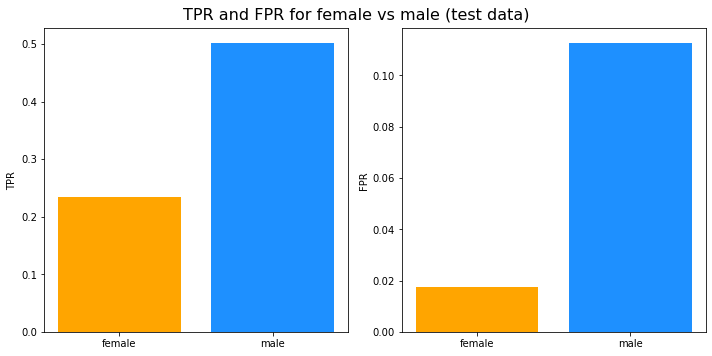

In [10]:
# Run the binary classification pipeline on the original processed data and evaluation on training data
female_tup, male_tup = adult_binary_classification_pipeline(X_train, y_train, X_test, y_test, evaluate="test")

# Calculate and visualize TPR and FPR on the training data for female and male
TPR_f_non_priv, TPR_m_non_priv, FPR_f_non_priv, FPR_m_non_priv = adult_fairness_summary(female_tup, male_tup, show_plots=True, evaluate="test")

In [11]:
# Calculate the difference in TPR (Equalized Opportunity distance)
TPR_diff_non_priv = TPR_m_non_priv-TPR_f_non_priv

# Calculate the difference in FPR (second Equalized Odds distance)
FPR_diff_non_priv = FPR_m_non_priv-FPR_f_non_priv

# Demographic parity (FP + TP rate difference)
dem_parity_non_priv = (FPR_m_non_priv+TPR_m_non_priv)-(FPR_f_non_priv+TPR_f_non_priv)

# Calculate overall accuracy for female and male
ACC_f_non_priv = (female_tup[0] + female_tup[2]) / sum(female_tup)
ACC_m_non_priv = (male_tup[0] + male_tup[2]) / sum(male_tup)

print("TRAINING DATA METRICS:")
print(f"The difference in TPR (equalized opportunity) is: {TPR_diff_non_priv:.4f}")
print(f"The difference in FPR (equalized odds) is: {FPR_diff_non_priv:.4f}")
print(f"The difference in FP + TP rate (Demographic Parity) is: {dem_parity_non_priv:.4f}")
print(f"The overall accuracy for female is: {ACC_f_non_priv:.4f}")
print(f"The overall accuracy for male is: {ACC_m_non_priv:.4f}")

TRAINING DATA METRICS:
The difference in TPR (equalized opportunity) is: 0.2681
The difference in FPR (equalized odds) is: 0.0954
The difference in FP + TP rate (Demographic Parity) is: 0.3635
The overall accuracy for female is: 0.8971
The overall accuracy for male is: 0.7640


## 4.2 MWEM

### 4.2.1 Data preparation

Based on multiplicative weight update mechanism; requires binning of continuous data.

In [12]:
# Recombine X_train and y_train for synthesis
adult_train = pd.concat([X_train, y_train], axis=1)
adult_train

,age,workclass,education,education_num,occupation,relationship,race,sex,hours_week,label
15213,24,0,1,13,-2,2,0,0,50,0
5841,50,0,-2,14,0,-3,0,1,60,0
26610,41,1,-1,10,-2,2,-1,0,40,0
30332,39,0,0,9,3,-1,-1,1,40,0
26117,46,0,0,9,-3,0,0,1,50,0
...,...,...,...,...,...,...,...,...,...,...
13918,55,0,1,13,3,-2,0,0,40,0
20822,50,2,-1,10,1,-2,0,0,75,0
10456,27,0,2,11,3,-1,0,1,40,0
11475,28,1,-1,10,1,0,0,1,65,0


In [13]:
# Recombine X_test and y_test for synthesis
adult_test = pd.concat([X_test, y_test], axis=1)

### 4.2.2 Varying $\varepsilon$

In [14]:
def get_synthesizer(synthesizer, epsilon):

    # Instantiate an MWEM synthesizer
    if synthesizer == "MWEM":
        synth = MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15, 
        splits=[], split_factor=2, max_bin_count=400)

    return synth

In [15]:
def get_quail_synthesizer(synthesizer, classifier, epsilon, eps_split, target):

    # Instantiate an MWEM synthesizer
    if synthesizer == "MWEM":
        def QuailSynth(epsilon):
            return MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15, 
                                    splits=[], split_factor=2, max_bin_count=400)
    
    # Instantiate a DPLR classifier
    if classifier == "DPLR":
        def QuailClassifier(epsilon):
            return DPLR(epsilon=epsilon)

    # Create a QUAIL synthesizer with base synthesizer and DP classifier
    quail = QUAILSynthesizer(epsilon, QuailSynth, QuailClassifier, target, eps_split)

    return quail

In [16]:
def adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", 
                                    quail=False, classifier=None, eps_split=None, n_reps=1):
    '''
    Calculates fairness metrics for binary
    classification on Adult data obtained by
    training classifier on synthetic training
    data and testing on non-private test data.
    
    INPUTS
    ======
    epsilon_vals: list containing privacy loss
    parameter values to apply, array-like
    adult_train: non-private training data (X and 
    y) to train synthesizer, pandas DataFrame
    adult_test: non-private test data (X and y)
    synthesizer: the type of synthesizer to use, str
    n_reps: the number of synthetic data sets to
    generate for each epsilon, int
    
    RETURNS
    =======
    Dictionary where each key is an epsilon and 
    each value is a list of four lists containing
    the TPR_f, TPR_m, FPR_f, FPR_m values obtained
    (e.g. each list will have two values if n_reps=2)
    '''
    
    # Initialize dictionary of fairness metrics
    fairness_dict = {}
    
    for epsilon in epsilon_vals:
        
        for i in range(n_reps):

            if quail:  
                # Create a QUAIL-wrapped synthesizer
                quail = get_quail_synthesizer(synthesizer, classifier, epsilon, eps_split, target="label")

                # Fit synthesizer to the training data
                quail.fit(adult_train)

                # Create private synthetic data
                adult_train_synth = quail.sample(int(adult_train.shape[0]))

            else:
                # Create a regular synthesizer
                synth = get_synthesizer(synthesizer, epsilon)
        
                # Fit synthesizer to the training data
                synth.fit(adult_train.to_numpy())
                
                # Create private synthetic data
                adult_train_synth = pd.DataFrame(synth.sample(int(adult_train.shape[0])), columns=adult_train.columns)
            
            # Split synthetic training data into X and y
            X_train, y_train = adult_train_synth.drop(["label"], axis=1), adult_train_synth["label"]
            
            # Split the non-private test data into X and y
            X_test, y_test = adult_test.drop(["label"], axis=1), adult_test["label"]
            
            # Run the binary classification pipeline
            female_tup, male_tup = adult_binary_classification_pipeline(X_train, y_train, X_test, y_test)
            
            # Add female and male tuples to dictionary
            if epsilon not in fairness_dict.keys():
                fairness_dict[epsilon] = [[female_tup], [male_tup]]
            else:
                fairness_dict[epsilon][0].append(female_tup)
                fairness_dict[epsilon][1].append(male_tup)
                
            print(f"Completed eps={epsilon}, rep={i+1}.")
        
    return fairness_dict

In [17]:
try:
    # Try to load the dictionary with one repetition
    adult_fairness_mwem_1 = np.load("adult_fairness_mwem_1.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

    # Get dictionary of fairness metrics with 1 repetition for range of values
    adult_fairness_mwem_1 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", n_reps=1)
    
    # Save dictionary
    np.save("adult_fairness_mwem_1.npy", adult_fairness_mwem_1)

In [18]:
def get_fairness_arrays(fairness_dict):
    
    # Initialize lists to hold epsilon and fairness metrics
    epsilon_vals = []
    tpr_f_arr = []
    tpr_m_arr = []
    fpr_f_arr = []
    fpr_m_arr = []
    tpr_diff_arr = []
    fpr_diff_arr = []
    acc_f_arr = []
    acc_m_arr = []

    # Loop through the dictionary of results
    for epsilon, metric_list in fairness_dict.items():

        # Get the metrics for female and male
        female_arr, male_arr = metric_list
        n_reps = len(female_arr)
        epsilon_vals.append(epsilon)

        # Initialize more lists
        if n_reps > 1:
            tpr_f_vals = []
            tpr_m_vals = []
            fpr_f_vals = []
            fpr_m_vals = []
            tpr_diff_vals = []
            fpr_diff_vals = []
            acc_f_vals = []
            acc_m_vals = []
        
        # Loop through the tuples
        for female_tup, male_tup in zip(female_arr, male_arr):
        
            # Get the fairness metrics
            TPR_f, TPR_m, FPR_f, FPR_m = adult_fairness_summary(female_tup, male_tup)

            # Calculate the equalized odds distances
            tpr_diff = TPR_m-TPR_f
            fpr_diff = FPR_m-FPR_f
            
            # Calculate the accuracies
            acc_f = (female_tup[0] + female_tup[2]) / sum(female_tup)
            acc_m = (male_tup[0] + male_tup[2]) / sum(male_tup)
            
            # Append metrics to arrays
            if n_reps > 1:
                tpr_f_vals.append(TPR_f)
                tpr_m_vals.append(TPR_m)
                fpr_f_vals.append(FPR_f)
                fpr_m_vals.append(FPR_m)
                tpr_diff_vals.append(tpr_diff)
                fpr_diff_vals.append(fpr_diff)
                acc_f_vals.append(acc_f)
                acc_m_vals.append(acc_m)
            else:
                tpr_f_arr.append(TPR_f)
                tpr_m_arr.append(TPR_m)
                fpr_f_arr.append(FPR_f)
                fpr_m_arr.append(FPR_m)
                tpr_diff_arr.append(tpr_diff)
                fpr_diff_arr.append(fpr_diff)
                acc_f_arr.append(acc_f)
                acc_m_arr.append(acc_m)
            
        # Add lists to arrays
        if n_reps > 1:
            tpr_f_arr.append(tpr_f_vals)
            tpr_m_arr.append(tpr_m_vals)
            fpr_f_arr.append(fpr_f_vals)
            fpr_m_arr.append(fpr_m_vals)
            tpr_diff_arr.append(tpr_diff_vals)
            fpr_diff_arr.append(fpr_diff_vals)
            acc_f_arr.append(acc_f_vals)
            acc_m_arr.append(acc_m_vals)
        
    return epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr

In [19]:
def plot_fairness_dict(fairness_dict, plot_non_private=False):

    # Get fairness arrays for plotting
    epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr = get_fairness_arrays(fairness_dict)    

    # Line plot if there was only one repetition
    if isinstance(tpr_f_arr[0], float):
        
        # Initialize a figure
        fig, axs = plt.subplots(2, 2, figsize=(15,12))
        axs = axs.ravel()
        
        if plot_non_private:
            min_eps = np.min(epsilon_vals)
            max_eps = np.max(epsilon_vals)
            axs[0].hlines(TPR_f_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private female TPR")
            axs[0].hlines(TPR_m_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private male TPR")            
            axs[1].hlines(FPR_f_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private female FPR")
            axs[1].hlines(FPR_m_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private male FPR")    
            axs[2].hlines(TPR_diff_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private TPR dist")
            axs[2].hlines(FPR_diff_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private FPR dist")
            axs[3].hlines(ACC_f_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private Female")
            axs[3].hlines(ACC_m_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private Male")
        axs[0].plot(epsilon_vals, tpr_f_arr, label="Female TPR", c="darkorange", marker='o')
        axs[0].plot(epsilon_vals, tpr_m_arr, label="Male TPR", c="royalblue", marker='o')
        axs[0].set_ylabel("True positive rate")
        axs[0].set_title("True positive rates for female vs male")
        axs[1].plot(epsilon_vals, fpr_f_arr, label="Female FPR", c="darkorange", marker='o')
        axs[1].plot(epsilon_vals, fpr_m_arr, label="Male FPR", c="royalblue", marker='o')
        axs[1].set_ylabel("False positive rate")
        axs[1].set_title("False positive rates for female vs male")
        axs[2].hlines(0, xmin=min_eps, xmax=max_eps, colors="grey", linestyles="--", label="Perfect fairness")
        axs[2].plot(epsilon_vals, tpr_diff_arr, label="TPR dist", c="darkorange", marker='o')
        axs[2].plot(epsilon_vals, fpr_diff_arr, label="FPR dist", c="royalblue", marker='o')
        axs[2].set_ylabel("Equalized odds distance")
        axs[2].set_title("Equalized odds distances for female vs male")
        axs[3].plot(epsilon_vals, acc_f_arr, label="Female", c="darkorange", marker='o')
        axs[3].plot(epsilon_vals, acc_m_arr, label="Male", c="royalblue", marker='o')
        axs[3].set_ylabel("Overall accuracy")
        axs[3].set_title("Classification accuracies for female vs male")
        fig.suptitle("Adult dataset fairness metrics (1 repetition)", fontsize=16)
        for i in range(4):
            axs[i].set_xlabel("Privacy loss (epsilon)")
            axs[i].legend()
    else:
        
        # Initialize a figure
        fig, axs = plt.subplots(4, 2, figsize=(15,20))
        axs = axs.ravel()
        
        # Prepare for plotting
        n_reps = len(tpr_f_arr[0])
        medianprops_f = dict(color='darkorange')
        medianprops_m = dict(color='royalblue')
        
        if plot_non_private:
            min_eps = 0.5
            max_eps = len(epsilon_vals)+0.5
            axs[0].hlines(TPR_f_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private female TPR")
            axs[1].hlines(TPR_m_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private male TPR")            
            axs[2].hlines(FPR_f_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private female FPR")
            axs[3].hlines(FPR_m_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private male FPR")    
            axs[4].hlines(TPR_diff_non_priv, xmin=min_eps, xmax=max_eps, colors="red", linestyles="--", label="Non-private TPR dist")
            axs[5].hlines(FPR_diff_non_priv, xmin=min_eps, xmax=max_eps, colors="red", linestyles="--", label="Non-private FPR dist")
            axs[6].hlines(ACC_f_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private Female")
            axs[7].hlines(ACC_m_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private Male")
        axs[0].boxplot(tpr_f_arr, medianprops=medianprops_f)
        axs[0].set_ylabel("True positive rate")
        axs[0].set_title("True positive rates for female")
        axs[1].boxplot(tpr_m_arr, medianprops=medianprops_m)
        axs[1].set_ylabel("True positive rate")
        axs[1].set_title("True positive rates for male")  
        axs[2].boxplot(fpr_f_arr, medianprops=medianprops_f)
        axs[2].set_ylabel("False positive rate")
        axs[2].set_title("False positive rates for female")        
        axs[3].boxplot(fpr_m_arr, medianprops=medianprops_m)
        axs[3].set_ylabel("False positive rate")
        axs[3].set_title("False positive rates for male")
        axs[4].boxplot(tpr_diff_arr, medianprops=dict(color="red"))
        axs[4].set_ylabel("Equalized odds distance (y=1)")
        axs[4].set_title("Equalized odds distances (y=1)")
        axs[4].hlines(0, xmin=min_eps, xmax=max_eps, colors="grey", linestyles="--", label="Perfect fairness")       
        axs[5].boxplot(fpr_diff_arr, medianprops=dict(color="red"))
        axs[5].set_ylabel("Equalized odds distances (y=0)")
        axs[5].set_title("Equalized odds distances (y=0)")
        axs[5].hlines(0, xmin=min_eps, xmax=max_eps, colors="grey", linestyles="--", label="Perfect fairness")
        axs[6].boxplot(acc_f_arr, medianprops=medianprops_f)
        axs[6].set_ylabel("Overall accuracy")
        axs[6].set_title("Classification accuracies for female")  
        axs[7].boxplot(acc_m_arr, medianprops=medianprops_m)
        axs[7].set_ylabel("Overall accuracy")
        axs[7].set_title("Classification accuracies for male")
        fig.suptitle(f"Adult dataset fairness metrics ({n_reps} repetitions)", fontsize=16)
        for i in range(8):
            axs[i].set_xticklabels(epsilon_vals)
            axs[i].set_xlabel("Privacy loss (epsilon)")
            axs[i].legend()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

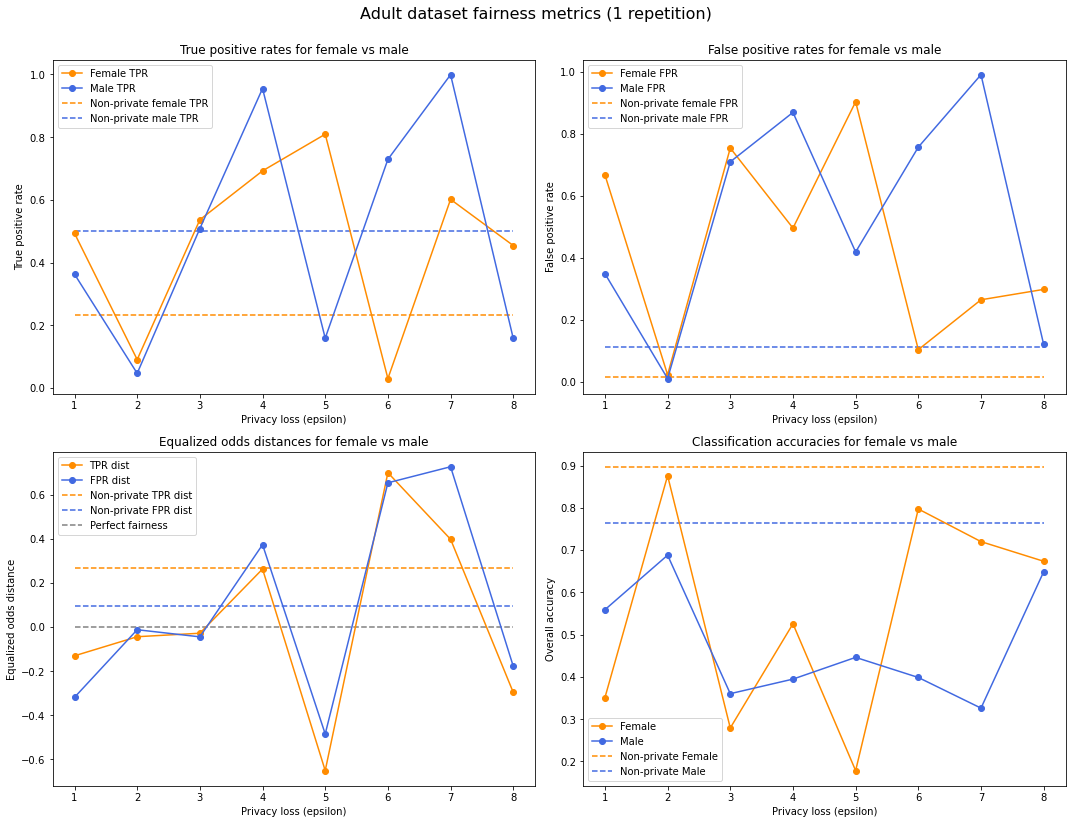

In [20]:
# Plot the fairness and accuracy metrics for 1 repetition
plot_fairness_dict(adult_fairness_mwem_1, plot_non_private=True)

In [21]:
try:
    # Try to load the dictionary with ten repetitions
    adult_fairness_mwem_2 = np.load("adult_fairness_mwem_2.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

    # Get dictionary of averaged fairness metrics across 10 repetitions for range of values
    adult_fairness_mwem_2 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", n_reps=15)
    
    # Save dictionary
    np.save("adult_fairness_mwem_2.npy", adult_fairness_mwem_2)

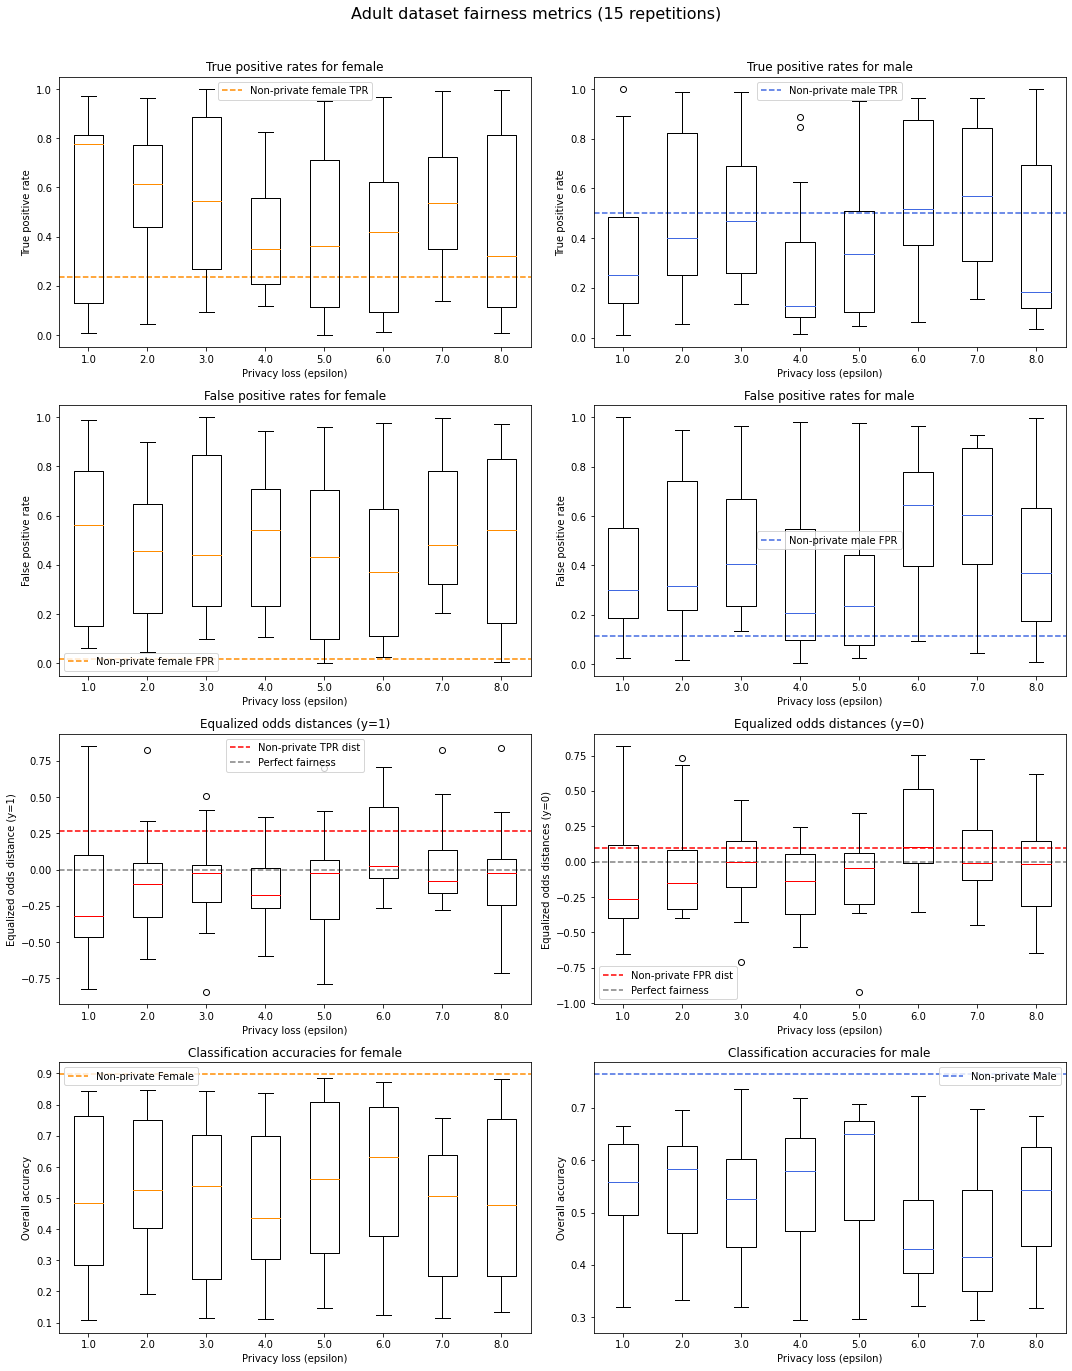

In [22]:
# Plot the fairness and accuracy metrics for female vs male
plot_fairness_dict(adult_fairness_mwem_2, plot_non_private=True)

- orders of magnitude trend of epsilons would show a more clear trend

## 4.3 QUAIL-MWEM

In [23]:
try:
    # Try to load the dictionary with ten repetitions
    adult_fairness_quail_mwem = np.load("adult_fairness_quail_mwem.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

    # Get dictionary of averaged fairness metrics across 10 repetitions for range of values
    adult_fairness_quail_mwem = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", 
                                                        quail=True, classifier="DPLR", eps_split=0.8, n_reps=15)
    
    # Save dictionary
    np.save("adult_fairness_quail_mwem.npy", adult_fairness_quail_mwem)

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=1.0, rep=1.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=1.0, rep=2.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=1.0, rep=3.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=1.0, rep=4.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=1.0, rep=5.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=1.0, rep=6.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=1.0, rep=7.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=1.0, rep=8.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=1.0, rep=9.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=1.0, rep=10.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=1.0, rep=11.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=1.0, rep=12.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=1.0, rep=13.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=1.0, rep=14.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=1.0, rep=15.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=2.0, rep=1.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=2.0, rep=2.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=2.0, rep=3.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=2.0, rep=4.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=2.0, rep=5.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=2.0, rep=6.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=2.0, rep=7.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=2.0, rep=8.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=2.0, rep=9.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=2.0, rep=10.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=2.0, rep=11.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=2.0, rep=12.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=2.0, rep=13.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=2.0, rep=14.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=2.0, rep=15.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=3.0, rep=1.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=3.0, rep=2.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=3.0, rep=3.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=3.0, rep=4.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=3.0, rep=5.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=3.0, rep=6.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=3.0, rep=7.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=3.0, rep=8.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=3.0, rep=9.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=3.0, rep=10.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=3.0, rep=11.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=3.0, rep=12.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=3.0, rep=13.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=3.0, rep=14.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=3.0, rep=15.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=4.0, rep=1.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=4.0, rep=2.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=4.0, rep=3.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=4.0, rep=4.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=4.0, rep=5.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=4.0, rep=6.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=4.0, rep=7.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=4.0, rep=8.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=4.0, rep=9.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=4.0, rep=10.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=4.0, rep=11.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=4.0, rep=12.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=4.0, rep=13.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=4.0, rep=14.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=4.0, rep=15.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=5.0, rep=1.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=5.0, rep=2.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=5.0, rep=3.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=5.0, rep=4.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=5.0, rep=5.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=5.0, rep=6.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=5.0, rep=7.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=5.0, rep=8.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=5.0, rep=9.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=5.0, rep=10.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=5.0, rep=11.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=5.0, rep=12.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=5.0, rep=13.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=5.0, rep=14.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=5.0, rep=15.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=6.0, rep=1.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=6.0, rep=2.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=6.0, rep=3.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=6.0, rep=4.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=6.0, rep=5.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=6.0, rep=6.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=6.0, rep=7.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=6.0, rep=8.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=6.0, rep=9.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=6.0, rep=10.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=6.0, rep=11.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=6.0, rep=12.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=6.0, rep=13.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=6.0, rep=14.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=6.0, rep=15.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:

Completed eps=7.0, rep=1.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=7.0, rep=2.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=7.0, rep=3.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=7.0, rep=4.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=7.0, rep=5.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=7.0, rep=6.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=7.0, rep=7.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=7.0, rep=8.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=7.0, rep=9.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=7.0, rep=10.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=7.0, rep=11.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=7.0, rep=12.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=7.0, rep=13.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=7.0, rep=14.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=7.0, rep=15.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=8.0, rep=1.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=8.0, rep=2.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=8.0, rep=3.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=8.0, rep=4.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=8.0, rep=5.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=8.0, rep=6.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=8.0, rep=7.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=8.0, rep=8.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=8.0, rep=9.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=8.0, rep=10.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=8.0, rep=11.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=8.0, rep=12.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=8.0, rep=13.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=8.0, rep=14.


C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Blake Bullwinkel\Documents\Harvard\Fall 2021\Capstone\smartnoise-sdk\synth\snsynth\mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Completed eps=8.0, rep=15.


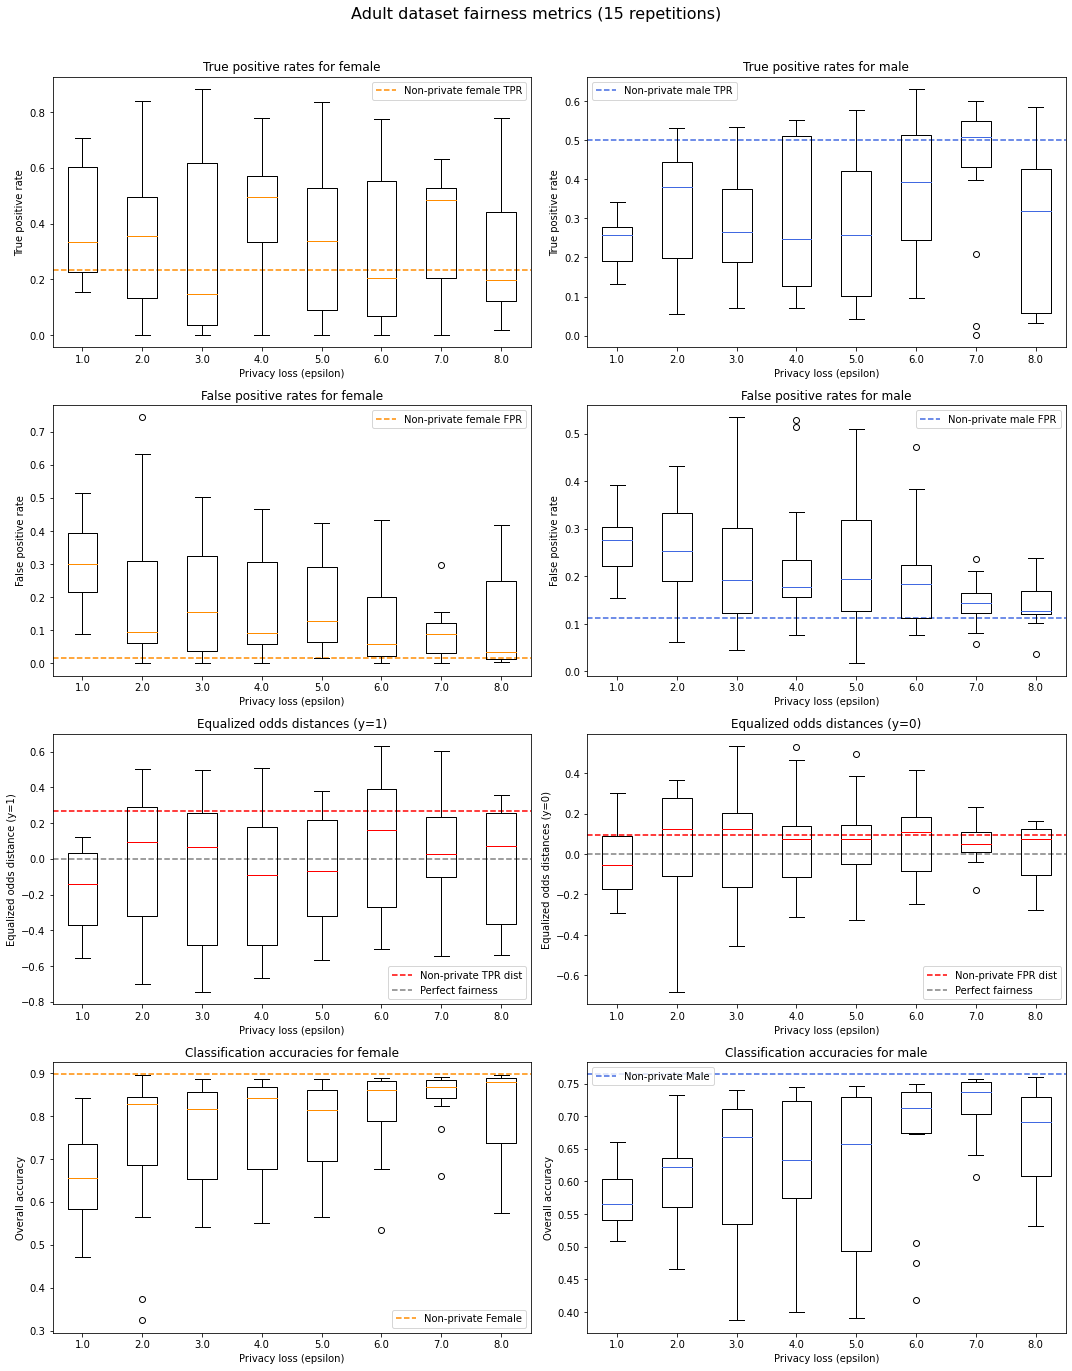

In [24]:
# Plot the fairness and accuracy metrics for female vs male
plot_fairness_dict(adult_fairness_quail_mwem, plot_non_private=True)

## 4.4 DPCTGAN

In [25]:
# Testing
dpctgan = PytorchDPSynthesizer(3.0, DPCTGAN(), None)
dpctgan.fit(adult_train, categorical_columns=["workclass", "education", "occupation", "relationship", "race", "sex", "label"])

C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\Public\anaconda3\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments wi

Epoch 1, Loss G: 0.6850, Loss D: 1.3904
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6762, Loss D: 1.4020
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6818, Loss D: 1.3879
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6806, Loss D: 1.3857
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6823, Loss D: 1.3904
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6776, Loss D: 1.3807
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6785, Loss D: 1.3968
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6818, Loss D: 1.3852
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6775, Loss D: 1.4022
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6785, Loss D: 1.3966
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6860, Loss D: 1.3890
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6875, Loss D: 1.3938
epsilon is 0.49822

epsilon is 1.556207584636917, alpha is 10.8
Epoch 97, Loss G: 0.6697, Loss D: 1.4038
epsilon is 1.5651892193778947, alpha is 10.7
Epoch 98, Loss G: 0.6785, Loss D: 1.3939
epsilon is 1.5741113982702355, alpha is 10.7
Epoch 99, Loss G: 0.6787, Loss D: 1.3772
epsilon is 1.5830215658157973, alpha is 10.6
Epoch 100, Loss G: 0.6908, Loss D: 1.3748
epsilon is 1.5918596228927195, alpha is 10.6
Epoch 101, Loss G: 0.6983, Loss D: 1.3901
epsilon is 1.6006976799696417, alpha is 10.6
Epoch 102, Loss G: 0.6929, Loss D: 1.3985
epsilon is 1.609458214712484, alpha is 10.5
Epoch 103, Loss G: 0.7120, Loss D: 1.3699
epsilon is 1.6182121640425107, alpha is 10.5
Epoch 104, Loss G: 0.7120, Loss D: 1.3722
epsilon is 1.626913385969906, alpha is 10.4
Epoch 105, Loss G: 0.6978, Loss D: 1.3609
epsilon is 1.6355832416168248, alpha is 10.4
Epoch 106, Loss G: 0.7004, Loss D: 1.3819
epsilon is 1.6442316189592925, alpha is 10.3
Epoch 107, Loss G: 0.7010, Loss D: 1.3859
epsilon is 1.6528173949821567, alpha is 10.3
Epoc

epsilon is 2.2914651326417554, alpha is 8.1
Epoch 193, Loss G: 0.6655, Loss D: 1.3685
epsilon is 2.2981839768173193, alpha is 8.0
Epoch 194, Loss G: 0.6895, Loss D: 1.3643
epsilon is 2.3048397909367457, alpha is 8.0
Epoch 195, Loss G: 0.6647, Loss D: 1.3659
epsilon is 2.311495605056172, alpha is 8.0
Epoch 196, Loss G: 0.6612, Loss D: 1.3870
epsilon is 2.3181514191755985, alpha is 8.0
Epoch 197, Loss G: 0.6617, Loss D: 1.3658
epsilon is 2.324807233295025, alpha is 8.0
Epoch 198, Loss G: 0.6257, Loss D: 1.4130
epsilon is 2.3314630474144518, alpha is 8.0
Epoch 199, Loss G: 0.6129, Loss D: 1.3871
epsilon is 2.3380922021851975, alpha is 7.9
Epoch 200, Loss G: 0.6365, Loss D: 1.4202
epsilon is 2.344664272684378, alpha is 7.9
Epoch 201, Loss G: 0.6442, Loss D: 1.4330
epsilon is 2.3512363431835586, alpha is 7.9
Epoch 202, Loss G: 0.6466, Loss D: 1.4119
epsilon is 2.3578084136827386, alpha is 7.9
Epoch 203, Loss G: 0.6543, Loss D: 1.3918
epsilon is 2.3643804841819196, alpha is 7.9
Epoch 204, Lo

epsilon is 2.8811602564481547, alpha is 6.8
Epoch 289, Loss G: 0.6030, Loss D: 1.4253
epsilon is 2.8868120662398247, alpha is 6.8
Epoch 290, Loss G: 0.6417, Loss D: 1.3891
epsilon is 2.892463876031495, alpha is 6.8
Epoch 291, Loss G: 0.6699, Loss D: 1.3682
epsilon is 2.8981156858231656, alpha is 6.8
Epoch 292, Loss G: 0.6155, Loss D: 1.4084
epsilon is 2.903767495614836, alpha is 6.8
Epoch 293, Loss G: 0.6231, Loss D: 1.4190
epsilon is 2.909419305406506, alpha is 6.8
Epoch 294, Loss G: 0.6290, Loss D: 1.3819
epsilon is 2.915071115198176, alpha is 6.8
Epoch 295, Loss G: 0.6224, Loss D: 1.4064
epsilon is 2.9207229249898465, alpha is 6.8
Epoch 296, Loss G: 0.6382, Loss D: 1.4290
epsilon is 2.926374734781517, alpha is 6.8
Epoch 297, Loss G: 0.6287, Loss D: 1.3604
epsilon is 2.932007533768708, alpha is 6.7
Epoch 298, Loss G: 0.6398, Loss D: 1.3880
epsilon is 2.937575766930928, alpha is 6.7
Epoch 299, Loss G: 0.6040, Loss D: 1.4325
epsilon is 2.9431440000931484, alpha is 6.7
Epoch 300, Loss G

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=aa928c63-0856-4021-a156-02d09e35182a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>